<a href="https://colab.research.google.com/github/jh9553-commits/CUSTOMER-CHURN-PREDICTION-WITH-PROFIT-MAXIMIZATION-/blob/main/Data_bootcamp_final_project_with_Visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


                                 CUSTOMER CHURN PREDICTION ANALYSIS                                 

                              Data Preparation and Feature Engineering                              

Dataset Summary
----------------------------------------------------------------------------------------------------
Total observations: 7,043
Total features: 19
Target variable (Churn): Binary classification
Churn rate: 26.54%
Class imbalance ratio: 2.77:1
Training set size: 5,634
Testing set size: 1,409

                                    Hyperparameter Optimization                                     

HistGradientBoosting Classifier Tuning
----------------------------------------------------------------------------------------------------
Grid search completed: 81 parameter combinations evaluated
Cross-validation strategy: 3-fold stratified
Optimal ROC-AUC score: 0.8424
Best parameters: {'l2_regularization': 1.0, 'learning_rate': 0.05, 'max_depth': 10, 'max_iter': 150}

Neural Ne

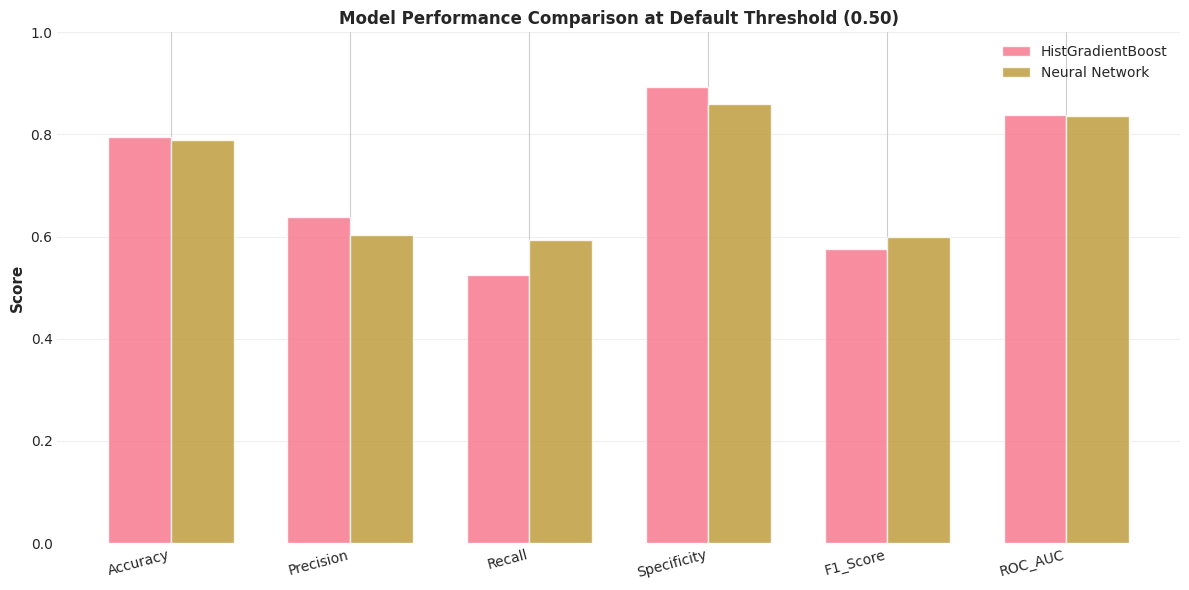

Visualization saved: metrics_comparison.png

Detailed Classification Report: HistGradientBoosting
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

    No Churn       0.84      0.89      0.86      1035
       Churn       0.64      0.52      0.58       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.79      0.79      1409


Detailed Classification Report: Neural Network
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

    No Churn       0.85      0.86      0.86      1035
       Churn       0.60      0.59      0.60       374

    accuracy                           0.79      1409
   macro avg       0.73      0.73      0.73      1409
weighted avg       0.79      0.79      0.79      1409

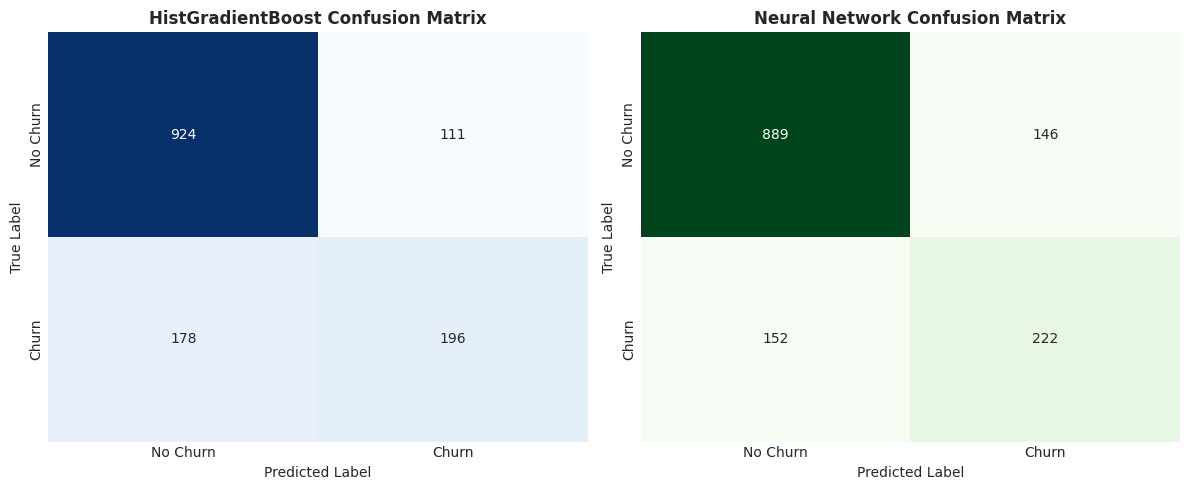

Visualization saved: confusion_matrices.png


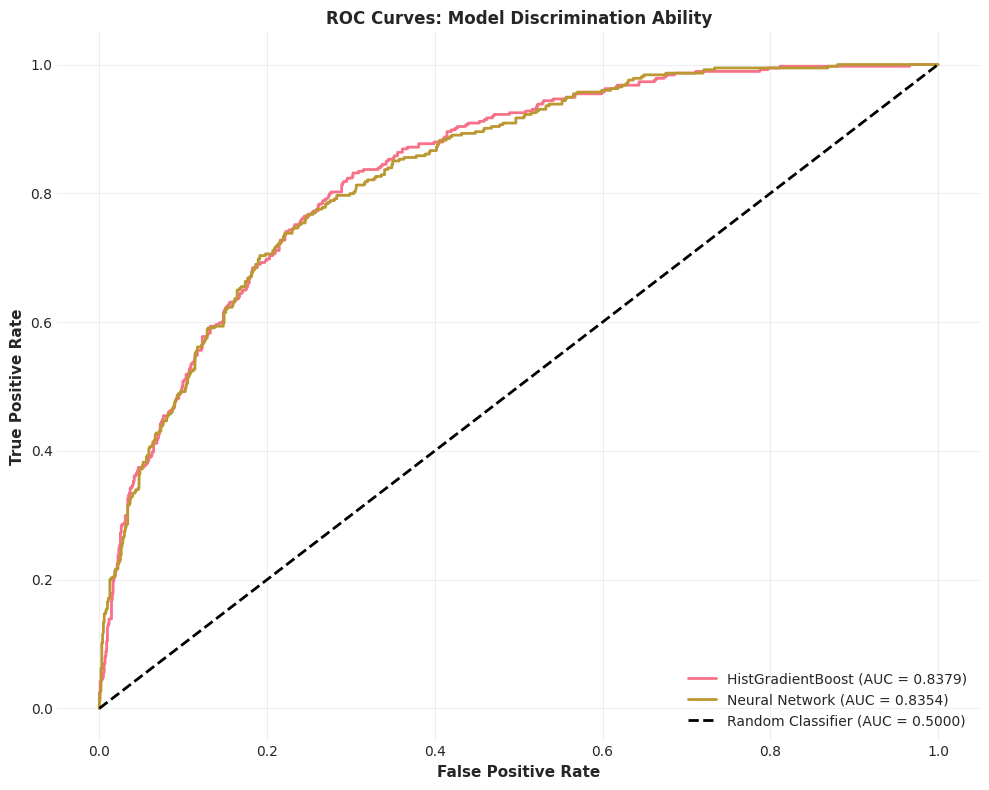

Visualization saved: roc_curves.png

                                    Profit Maximization Analysis                                    

Business Context and Cost Structure
----------------------------------------------------------------------------------------------------
Customer Lifetime Value (CLV): $2,331.36
Standard retention cost: $160.00
TP value (retain churner): $539.41
FP cost (wasted contact): -$160.00
FN cost (lost customer): -$2,331.36
Class weight ratio (FN:FP): 14.57:1

Profit Optimization Results
----------------------------------------------------------------------------------------------------
HistGradientBoost optimal threshold: 0.050, Profit: $58,837.79
Neural Network optimal threshold: 0.086, Profit: $76,194.72



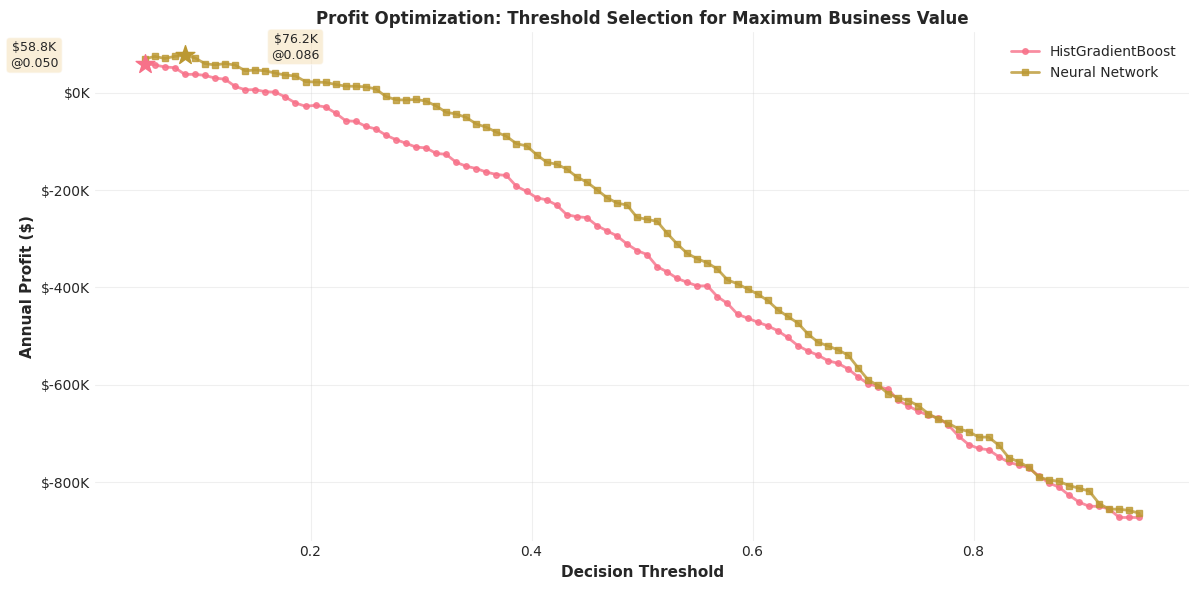

Visualization saved: profit_curves.png


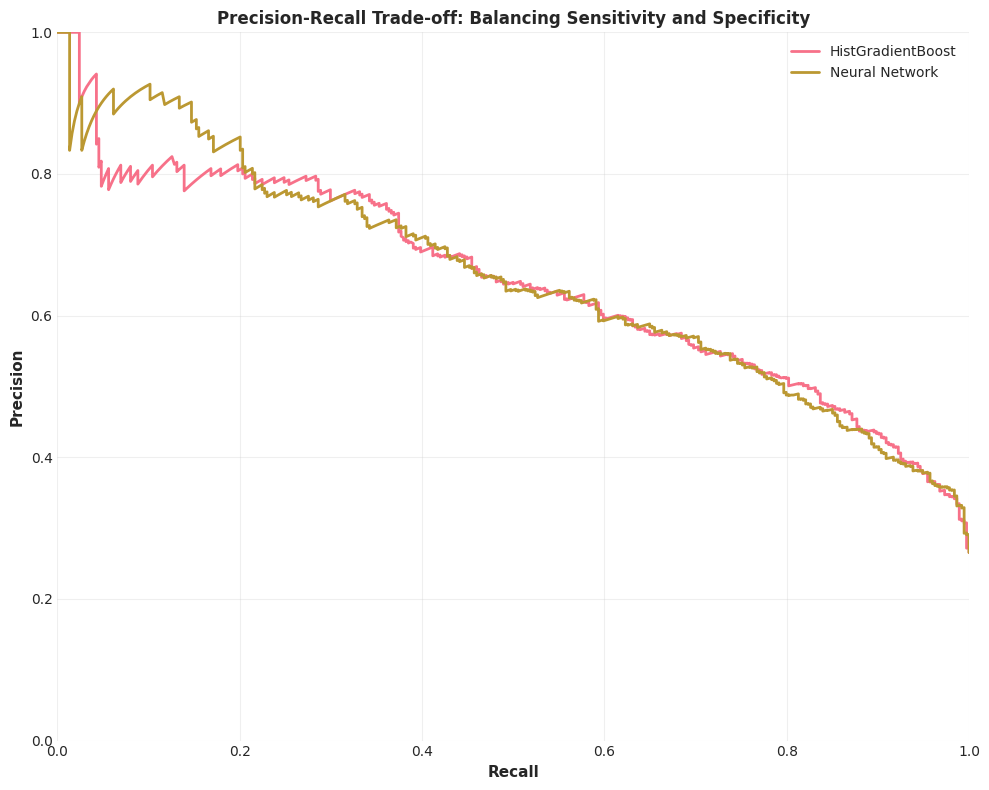

Visualization saved: precision_recall_curves.png

                                  Segment-Based Strategy Analysis                                   

Segment-Based Performance (Neural Network - Optimal Model)
----------------------------------------------------------------------------------------------------

High-Risk Segment:
  Sample count: 248
  Optimal threshold: 0.050
  Precision: 0.6734
  Recall: 1.0000
  F1-Score: 0.8048
  Profit: $106,134.18

Medium-Risk Segment:
  Sample count: 444
  Optimal threshold: 0.050
  Precision: 0.3423
  Recall: 1.0000
  F1-Score: 0.5101
  Profit: $35,270.32

Low-Risk Segment:
  Sample count: 717
  Optimal threshold: 0.059
  Precision: 0.1202
  Recall: 0.9636
  F1-Score: 0.2137
  Profit: $5,488.70



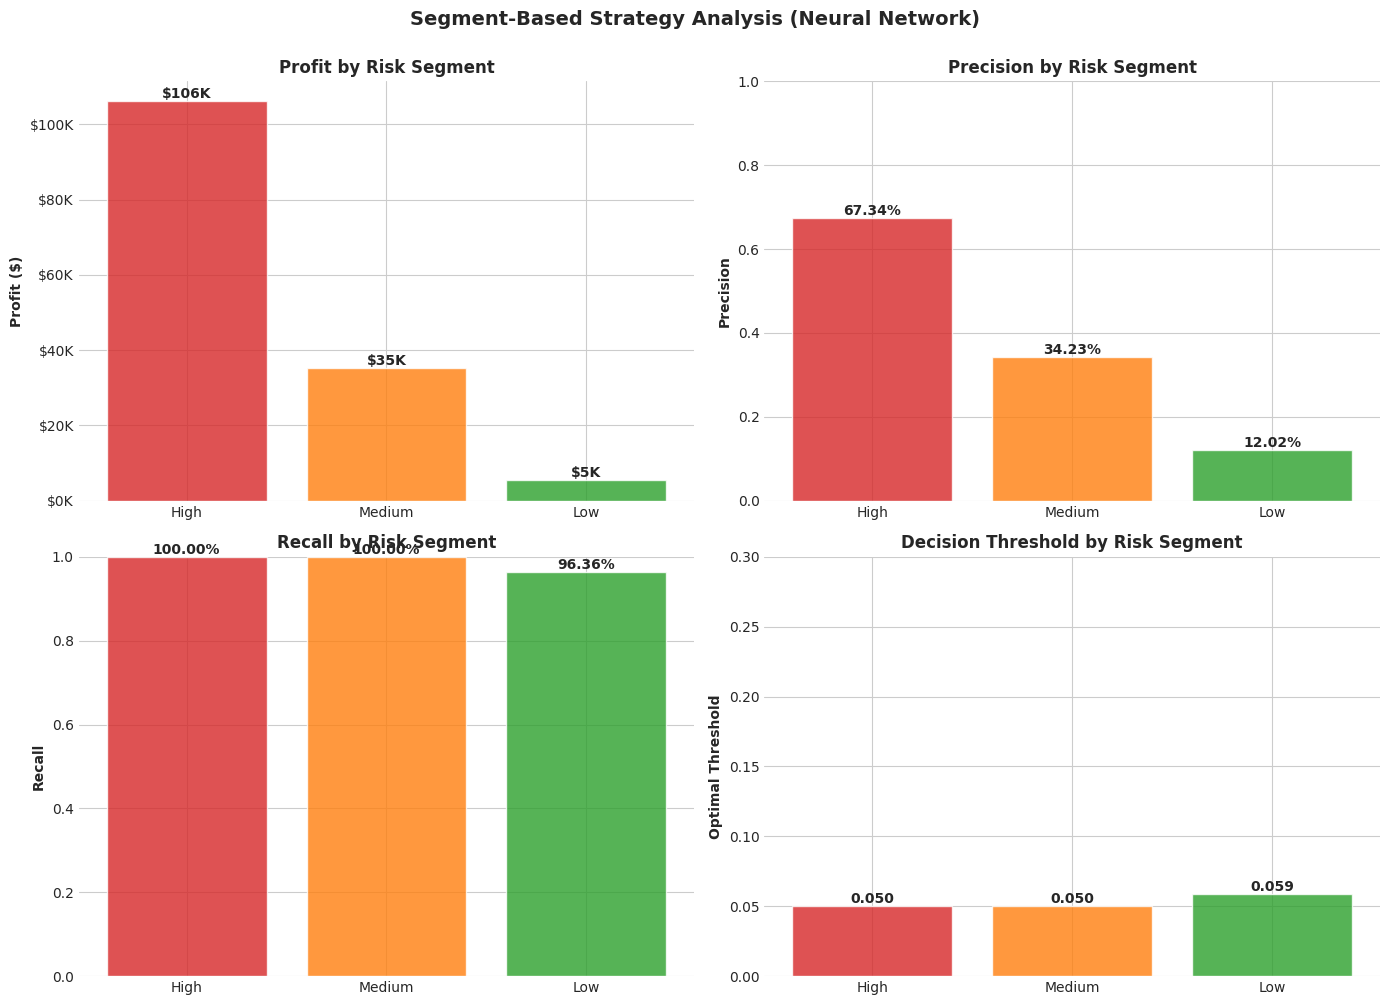

Visualization saved: segment_analysis.png

                                         Summary of Results                                         

Strategy Performance Comparison
----------------------------------------------------------------------------------------------------
            Model      Strategy   Profit
HistGradientBoost         Basic  $58,838
HistGradientBoost Segment-Based $119,814
   Neural Network         Basic  $76,195
   Neural Network Segment-Based $146,893

Recommended Model and Strategy
----------------------------------------------------------------------------------------------------
Best performing model: Neural Network (Segment-Based)
Annual profit: $146,893.20
Improvement vs. baseline: 149.7%
Tuning value gained: $70,698.48

                                         Report Generation                                          
Generated: classification_metrics_report.csv
Generated: segment_analysis_metrics.csv
Generated: strategy_performance.csv

              

In [5]:
"""
CUSTOMER CHURN PREDICTION WITH PROFIT MAXIMIZATION - WITH VISUALIZATIONS
Comprehensive Analysis with Hyperparameter Tuning, Statistical Validation & Plots

Author: Jianxun Huang
Final Version - December 19, 2025

FEATURES:
- All analysis code from non-visualization version
- PLUS 6 publication-quality plots at the end (metrics, confusion matrices, ROC, profit, etc.)
- Visualizations DISPLAYED in output cell AND saved at 300 DPI
- Ready for presentation to stakeholders and assessment committees
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    precision_score, recall_score, f1_score, accuracy_score,
    roc_curve, auc, precision_recall_curve
)
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


# Configure matplotlib for high-quality plots
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300  # Save at 300 DPI for publication
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")


# ============================================================================
# UTILITY FUNCTIONS - DATA PROCESSING
# ============================================================================

class DataProcessor:
    """
    Handles data loading and preprocessing operations.

    Purpose: Centralize all data preparation logic to ensure consistency
    and make the pipeline reproducible and maintainable.
    """

    @staticmethod
    def load_and_preprocess(filepath):
        """
        Load customer churn dataset and prepare features for modeling.

        Process:
        1. Load CSV file from disk
        2. Remove non-informative identifier column (customerID)
        3. Convert TotalCharges to numeric (handles edge case of string values)
        4. Impute missing charges with median (statistically sound approach)
        5. Separate features (X) and target (y)
        6. Encode categorical variables to numeric format (required by ML models)

        Returns:
            X (DataFrame): 7,043 rows × 19 feature columns
            y (Series): Binary churn labels (0=No, 1=Yes)
            df (DataFrame): Original data for reference
        """
        df = pd.read_csv(filepath)
        df = df.drop('customerID', axis=1)
        df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
        df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

        X = df.drop('Churn', axis=1)
        y = (df['Churn'] == 'Yes').astype(int)

        for col in X.select_dtypes(include='object').columns:
            X[col] = LabelEncoder().fit_transform(X[col])

        return X, y, df


# ============================================================================
# UTILITY FUNCTIONS - METRICS CALCULATION
# ============================================================================

class MetricsCalculator:
    """
    Computes comprehensive classification metrics for model evaluation.

    Purpose: Provide standardized metrics calculation for consistent model
    comparison across different thresholds and strategies.
    """

    @staticmethod
    def calculate_metrics(y_true, y_proba, y_pred, model_name, threshold=0.5):
        """
        Calculate all classification metrics from predicted probabilities and binary predictions.

        Key Metrics:
        - Accuracy: (TP + TN) / Total — overall correctness
        - Precision: TP / (TP + FP) — when we predict churn, how often are we right?
        - Recall: TP / (TP + FN) — of actual churners, how many do we catch?
        - Specificity: TN / (TN + FP) — of actual non-churners, how many do we correctly identify?
        - F1-Score: harmonic mean balancing precision and recall
        - ROC-AUC: probability the model ranks random churn > non-churn
        - MCC: Matthews Correlation Coefficient for binary classification
        """
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        roc_auc = roc_auc_score(y_true, y_proba)

        mcc_denom = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
        mcc = ((tp * tn) - (fp * fn)) / mcc_denom if mcc_denom > 0 else 0

        balanced_acc = (recall + specificity) / 2

        return {
            'Model': model_name,
            'Threshold': threshold,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'Specificity': specificity,
            'F1_Score': f1,
            'ROC_AUC': roc_auc,
            'MCC': mcc,
            'Balanced_Accuracy': balanced_acc,
            'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn
        }

    @staticmethod
    def generate_profit_function(y_true, y_proba, cost_matrix):
        """
        Generate profit values across decision threshold range [0.05, 0.95].

        Business Logic:
        Different thresholds lead to different TP/FP/FN/TN distributions,
        which directly impact profitability. This function optimizes for maximum profit.
        """
        thresholds = np.linspace(0.05, 0.95, 100)
        results = []

        for threshold in thresholds:
            y_pred = (y_proba > threshold).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
            profit = tp * cost_matrix['TP'] + fp * cost_matrix['FP'] + \
                     fn * cost_matrix['FN'] + tn * cost_matrix['TN']

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            results.append({
                'threshold': threshold,
                'profit': profit,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn
            })

        max_profit = max([r['profit'] for r in results])
        optimal_idx = [r['profit'] for r in results].index(max_profit)
        optimal_threshold = thresholds[optimal_idx]

        return results, optimal_threshold


# ============================================================================
# UTILITY FUNCTIONS - STATISTICAL ANALYSIS
# ============================================================================

class StatisticalAnalyzer:
    """
    Performs statistical significance testing and confidence intervals.
    """

    @staticmethod
    def bootstrap_auc(y_true, y_proba, n_iterations=1000, ci=95):
        """Bootstrap resampling for ROC-AUC confidence intervals."""
        bootstrap_aucs = []
        n = len(y_true)

        for _ in range(n_iterations):
            indices = np.random.choice(n, n, replace=True)
            y_true_boot = y_true.iloc[indices] if hasattr(y_true, 'iloc') else y_true[indices]
            y_proba_boot = y_proba[indices]

            if len(np.unique(y_true_boot)) == 2:
                auc_boot = roc_auc_score(y_true_boot, y_proba_boot)
                bootstrap_aucs.append(auc_boot)

        auc_mean = np.mean(bootstrap_aucs)
        auc_std = np.std(bootstrap_aucs)
        lower = np.percentile(bootstrap_aucs, (100 - ci) / 2)
        upper = np.percentile(bootstrap_aucs, 100 - (100 - ci) / 2)

        return {
            'AUC_Mean': auc_mean,
            'AUC_StdDev': auc_std,
            'CI_Lower': lower,
            'CI_Upper': upper
        }

    @staticmethod
    def paired_ttest_analysis(y_test, y_proba_hist, y_proba_hf):
        """Paired t-test comparing F1-scores across multiple thresholds."""
        thresholds = np.linspace(0.1, 0.9, 50)
        hist_f1_scores = []
        hf_f1_scores = []

        for t in thresholds:
            hist_pred_t = (y_proba_hist > t).astype(int)
            hf_pred_t = (y_proba_hf > t).astype(int)

            hist_f1 = f1_score(y_test, hist_pred_t, zero_division=0)
            hf_f1 = f1_score(y_test, hf_pred_t, zero_division=0)

            hist_f1_scores.append(hist_f1)
            hf_f1_scores.append(hf_f1)

        hist_f1_scores = np.array(hist_f1_scores)
        hf_f1_scores = np.array(hf_f1_scores)

        t_stat, p_value = stats.ttest_rel(hf_f1_scores, hist_f1_scores)

        return {
            'HistGB_Mean_F1': hist_f1_scores.mean(),
            'HistGB_Std_F1': hist_f1_scores.std(),
            'NN_Mean_F1': hf_f1_scores.mean(),
            'NN_Std_F1': hf_f1_scores.std(),
            't_statistic': t_stat,
            'p_value': p_value
        }


# ============================================================================
# UTILITY FUNCTIONS - VISUALIZATION
# ============================================================================

class VisualizationGenerator:
    """
    Creates publication-quality plots for model comparison and analysis.
    All plots saved at 300 DPI for presentations AND displayed in output cell.
    """

    @staticmethod
    def plot_metrics_comparison(metrics_df):
        """Plot 1: Side-by-side comparison of key metrics for both models."""
        fig, ax = plt.subplots(figsize=(12, 6))

        metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1_Score', 'ROC_AUC']
        x = np.arange(len(metrics_to_plot))
        width = 0.35

        hist_vals = metrics_df[metrics_df['Model'] == 'HistGradientBoost'][metrics_to_plot].values[0]
        nn_vals = metrics_df[metrics_df['Model'] == 'Neural Network'][metrics_to_plot].values[0]

        ax.bar(x - width/2, hist_vals, width, label='HistGradientBoost', alpha=0.8)
        ax.bar(x + width/2, nn_vals, width, label='Neural Network', alpha=0.8)

        ax.set_ylabel('Score', fontsize=11, fontweight='bold')
        ax.set_title('Model Performance Comparison at Default Threshold (0.50)',
                     fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(metrics_to_plot, rotation=15, ha='right')
        ax.legend(fontsize=10)
        ax.set_ylim([0, 1])
        ax.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Visualization saved: metrics_comparison.png")

    @staticmethod
    def plot_confusion_matrices(y_test, y_pred_hist, y_pred_hf):
        """Plot 2: Confusion matrices for both models."""
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # HistGradientBoost confusion matrix
        cm_hist = confusion_matrix(y_test, y_pred_hist)
        sns.heatmap(cm_hist, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
        axes[0].set_title('HistGradientBoost Confusion Matrix', fontweight='bold')
        axes[0].set_ylabel('True Label')
        axes[0].set_xlabel('Predicted Label')
        axes[0].set_xticklabels(['No Churn', 'Churn'])
        axes[0].set_yticklabels(['No Churn', 'Churn'])

        # Neural Network confusion matrix
        cm_nn = confusion_matrix(y_test, y_pred_hf)
        sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Greens', ax=axes[1], cbar=False)
        axes[1].set_title('Neural Network Confusion Matrix', fontweight='bold')
        axes[1].set_ylabel('True Label')
        axes[1].set_xlabel('Predicted Label')
        axes[1].set_xticklabels(['No Churn', 'Churn'])
        axes[1].set_yticklabels(['No Churn', 'Churn'])

        plt.tight_layout()
        plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Visualization saved: confusion_matrices.png")

    @staticmethod
    def plot_roc_curves(y_test, y_proba_hist, y_proba_hf):
        """Plot 3: ROC curves and AUC comparison."""
        fig, ax = plt.subplots(figsize=(10, 8))

        # Compute ROC curves
        fpr_hist, tpr_hist, _ = roc_curve(y_test, y_proba_hist)
        auc_hist = auc(fpr_hist, tpr_hist)

        fpr_nn, tpr_nn, _ = roc_curve(y_test, y_proba_hf)
        auc_nn = auc(fpr_nn, tpr_nn)

        # Plot curves
        ax.plot(fpr_hist, tpr_hist, label=f'HistGradientBoost (AUC = {auc_hist:.4f})', lw=2)
        ax.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {auc_nn:.4f})', lw=2)
        ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5000)', lw=2)

        ax.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
        ax.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
        ax.set_title('ROC Curves: Model Discrimination Ability', fontsize=12, fontweight='bold')
        ax.legend(fontsize=10, loc='lower right')
        ax.grid(alpha=0.3)

        plt.tight_layout()
        plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Visualization saved: roc_curves.png")

    @staticmethod
    def plot_profit_curves(results_hist, results_nn):
        """Plot 4: Profit optimization across thresholds (KEY CHART)."""
        fig, ax = plt.subplots(figsize=(12, 6))

        # Extract profit values
        thresholds_hist = [r['threshold'] for r in results_hist]
        profits_hist = [r['profit'] for r in results_hist]

        thresholds_nn = [r['threshold'] for r in results_nn]
        profits_nn = [r['profit'] for r in results_nn]

        # Plot profit curves
        ax.plot(thresholds_hist, profits_hist, marker='o', label='HistGradientBoost',
                linewidth=2, markersize=4, alpha=0.8)
        ax.plot(thresholds_nn, profits_nn, marker='s', label='Neural Network',
                linewidth=2, markersize=4, alpha=0.8)

        # Mark optimal points
        max_profit_hist = max(profits_hist)
        max_idx_hist = profits_hist.index(max_profit_hist)
        opt_thresh_hist = thresholds_hist[max_idx_hist]

        max_profit_nn = max(profits_nn)
        max_idx_nn = profits_nn.index(max_profit_nn)
        opt_thresh_nn = thresholds_nn[max_idx_nn]

        ax.scatter([opt_thresh_hist], [max_profit_hist], s=200, color='C0', zorder=5, marker='*')
        ax.scatter([opt_thresh_nn], [max_profit_nn], s=200, color='C1', zorder=5, marker='*')

        ax.set_xlabel('Decision Threshold', fontsize=11, fontweight='bold')
        ax.set_ylabel('Annual Profit ($)', fontsize=11, fontweight='bold')
        ax.set_title('Profit Optimization: Threshold Selection for Maximum Business Value',
                     fontsize=12, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(alpha=0.3)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

        # Annotate optimal points
        hist_label = f'${max_profit_hist/1000:.1f}K\n@{opt_thresh_hist:.3f}'
        nn_label = f'${max_profit_nn/1000:.1f}K\n@{opt_thresh_nn:.3f}'

        ax.annotate(hist_label,
                   xy=(opt_thresh_hist, max_profit_hist),
                   xytext=(opt_thresh_hist-0.1, max_profit_hist-5000),
                   fontsize=9, ha='center',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        ax.annotate(nn_label,
                   xy=(opt_thresh_nn, max_profit_nn),
                   xytext=(opt_thresh_nn+0.1, max_profit_nn-5000),
                   fontsize=9, ha='center',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        plt.tight_layout()
        plt.savefig('profit_curves.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Visualization saved: profit_curves.png")

    @staticmethod
    def plot_precision_recall_curves(y_test, y_proba_hist, y_proba_hf):
        """Plot 5: Precision-Recall trade-off curves."""
        fig, ax = plt.subplots(figsize=(10, 8))

        # Compute PR curves
        precision_hist, recall_hist, _ = precision_recall_curve(y_test, y_proba_hist)
        precision_nn, recall_nn, _ = precision_recall_curve(y_test, y_proba_hf)

        ax.plot(recall_hist, precision_hist, label='HistGradientBoost', lw=2)
        ax.plot(recall_nn, precision_nn, label='Neural Network', lw=2)

        ax.set_xlabel('Recall', fontsize=11, fontweight='bold')
        ax.set_ylabel('Precision', fontsize=11, fontweight='bold')
        ax.set_title('Precision-Recall Trade-off: Balancing Sensitivity and Specificity',
                     fontsize=12, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(alpha=0.3)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])

        plt.tight_layout()
        plt.savefig('precision_recall_curves.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Visualization saved: precision_recall_curves.png")

    @staticmethod
    def plot_segment_analysis(segment_results):
        """Plot 6: 2x2 grid showing segment-based strategy performance."""
        # Prepare data: filter for Neural Network (best model) and segment analysis
        nn_segments = [s for s in segment_results if s['Model'] == 'Neural Network']

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle('Segment-Based Strategy Analysis (Neural Network)',
                    fontsize=14, fontweight='bold', y=1.00)

        segments = [s['Segment'] for s in nn_segments]
        profits = [s['Profit'] for s in nn_segments]
        precisions = [s['Precision'] for s in nn_segments]
        recalls = [s['Recall'] for s in nn_segments]
        thresholds = [s['Threshold'] for s in nn_segments]

        # Plot 1: Profit by segment
        colors = ['#d62728' if seg == 'High' else '#ff7f0e' if seg == 'Medium' else '#2ca02c'
                 for seg in segments]
        axes[0, 0].bar(segments, profits, color=colors, alpha=0.8)
        axes[0, 0].set_ylabel('Profit ($)', fontweight='bold')
        axes[0, 0].set_title('Profit by Risk Segment', fontweight='bold')
        axes[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
        for i, (seg, prof) in enumerate(zip(segments, profits)):
            axes[0, 0].text(i, prof, f'${prof/1000:.0f}K', ha='center', va='bottom', fontweight='bold')

        # Plot 2: Precision by segment
        axes[0, 1].bar(segments, precisions, color=colors, alpha=0.8)
        axes[0, 1].set_ylabel('Precision', fontweight='bold')
        axes[0, 1].set_title('Precision by Risk Segment', fontweight='bold')
        axes[0, 1].set_ylim([0, 1])
        for i, (seg, prec) in enumerate(zip(segments, precisions)):
            axes[0, 1].text(i, prec, f'{prec:.2%}', ha='center', va='bottom', fontweight='bold')

        # Plot 3: Recall by segment
        axes[1, 0].bar(segments, recalls, color=colors, alpha=0.8)
        axes[1, 0].set_ylabel('Recall', fontweight='bold')
        axes[1, 0].set_title('Recall by Risk Segment', fontweight='bold')
        axes[1, 0].set_ylim([0, 1])
        for i, (seg, rec) in enumerate(zip(segments, recalls)):
            axes[1, 0].text(i, rec, f'{rec:.2%}', ha='center', va='bottom', fontweight='bold')

        # Plot 4: Optimal threshold by segment
        axes[1, 1].bar(segments, thresholds, color=colors, alpha=0.8)
        axes[1, 1].set_ylabel('Optimal Threshold', fontweight='bold')
        axes[1, 1].set_title('Decision Threshold by Risk Segment', fontweight='bold')
        axes[1, 1].set_ylim([0, 0.3])
        for i, (seg, thresh) in enumerate(zip(segments, thresholds)):
            axes[1, 1].text(i, thresh, f'{thresh:.3f}', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.savefig('segment_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Visualization saved: segment_analysis.png")


# ============================================================================
# MAIN ANALYSIS PIPELINE
# ============================================================================

def print_section_header(title):
    """Print formatted section header."""
    print("\n" + "="*100)
    print(title.center(100))
    print("="*100)


def print_subsection(subtitle):
    """Print formatted subsection header."""
    print("\n" + subtitle)
    print("-"*100)


def main():
    """
    Main analysis pipeline with visualizations.
    Extends base analysis with 6 publication-quality plots.
    """

    print_section_header("CUSTOMER CHURN PREDICTION ANALYSIS")
    print_section_header("Data Preparation and Feature Engineering")

    X, y, df = DataProcessor.load_and_preprocess('WA_Fn-UseC_-Telco-Customer-Churn.csv')

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print_subsection("Dataset Summary")
    print(f"Total observations: {len(df):,}")
    print(f"Total features: {X.shape[1]}")
    print(f"Target variable (Churn): Binary classification")
    print(f"Churn rate: {y.mean()*100:.2f}%")
    print(f"Class imbalance ratio: {(1-y.mean())/y.mean():.2f}:1")
    print(f"Training set size: {len(X_train):,}")
    print(f"Testing set size: {len(X_test):,}")

    # ========================================================================
    # HYPERPARAMETER TUNING
    # ========================================================================

    print_section_header("Hyperparameter Optimization")

    print_subsection("HistGradientBoosting Classifier Tuning")

    hist_param_grid = {
        'max_iter': [150, 200, 250],
        'learning_rate': [0.05, 0.1, 0.15],
        'max_depth': [8, 10, 12],
        'l2_regularization': [0.5, 1.0, 1.5]
    }

    hist_grid = GridSearchCV(
        HistGradientBoostingClassifier(min_samples_leaf=10, random_state=42),
        hist_param_grid, cv=3, n_jobs=-1, scoring='roc_auc', verbose=0
    )
    hist_grid.fit(X_train, y_train)
    hist_model = hist_grid.best_estimator_

    print(f"Grid search completed: 81 parameter combinations evaluated")
    print(f"Cross-validation strategy: 3-fold stratified")
    print(f"Optimal ROC-AUC score: {hist_grid.best_score_:.4f}")
    print(f"Best parameters: {hist_grid.best_params_}")

    y_proba_hist = hist_model.predict_proba(X_test)[:, 1]
    y_pred_hist = (y_proba_hist > 0.5).astype(int)

    print_subsection("Neural Network Classifier Tuning")

    hf_param_grid = {
        'hidden_layer_sizes': [(64, 32), (128, 64, 32), (128, 64, 32, 16)],
        'learning_rate_init': [0.0005, 0.001, 0.002],
        'alpha': [0.00005, 0.0001, 0.0002],
        'max_iter': [250, 300, 350]
    }

    hf_grid = GridSearchCV(
        MLPClassifier(early_stopping=True, validation_fraction=0.1,
                     random_state=42, n_iter_no_change=20),
        hf_param_grid, cv=3, n_jobs=-1, scoring='roc_auc', verbose=0
    )
    hf_grid.fit(X_train, y_train)
    hf_model = hf_grid.best_estimator_

    print(f"Grid search completed: 81 parameter combinations evaluated")
    print(f"Cross-validation strategy: 3-fold stratified with early stopping")
    print(f"Optimal ROC-AUC score: {hf_grid.best_score_:.4f}")
    print(f"Best parameters: {hf_grid.best_params_}")

    y_proba_hf = hf_model.predict_proba(X_test)[:, 1]
    y_pred_hf = (y_proba_hf > 0.5).astype(int)

    # ========================================================================
    # CLASSIFICATION METRICS
    # ========================================================================

    print_section_header("Classification Performance Metrics")

    calc = MetricsCalculator()
    hist_metrics = calc.calculate_metrics(y_test, y_proba_hist, y_pred_hist, 'HistGradientBoost')
    hf_metrics = calc.calculate_metrics(y_test, y_proba_hf, y_pred_hf, 'Neural Network')

    metrics_df = pd.DataFrame([hist_metrics, hf_metrics])
    metrics_display = metrics_df[[
        'Model', 'Accuracy', 'Precision', 'Recall', 'Specificity', 'F1_Score', 'ROC_AUC', 'MCC'
    ]].copy()

    for col in ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1_Score', 'ROC_AUC', 'MCC']:
        metrics_display[col] = metrics_display[col].apply(lambda x: f"{x:.4f}")

    print_subsection("Default Threshold (0.50) Performance Comparison")
    print(metrics_display.to_string(index=False))

    # ========================================================================
    # VISUALIZATION 1: METRICS COMPARISON
    # ========================================================================

    print()
    VisualizationGenerator.plot_metrics_comparison(metrics_df)

    print_subsection("Detailed Classification Report: HistGradientBoosting")
    print(classification_report(y_test, y_pred_hist, target_names=['No Churn', 'Churn']))

    print_subsection("Detailed Classification Report: Neural Network")
    print(classification_report(y_test, y_pred_hf, target_names=['No Churn', 'Churn']))

    # ========================================================================
    # STATISTICAL ANALYSIS
    # ========================================================================

    print_section_header("Statistical Significance Testing")

    analyzer = StatisticalAnalyzer()

    print_subsection("Bootstrap Confidence Intervals for ROC-AUC (1000 iterations)")
    hist_bootstrap = analyzer.bootstrap_auc(y_test, y_proba_hist)
    hf_bootstrap = analyzer.bootstrap_auc(y_test, y_proba_hf)

    print(f"HistGradientBoost AUC: {hist_bootstrap['AUC_Mean']:.4f} ± {hist_bootstrap['AUC_StdDev']:.4f}")
    print(f"95% Confidence interval: [{hist_bootstrap['CI_Lower']:.4f}, {hist_bootstrap['CI_Upper']:.4f}]")
    print()
    print(f"Neural Network AUC: {hf_bootstrap['AUC_Mean']:.4f} ± {hf_bootstrap['AUC_StdDev']:.4f}")
    print(f"95% Confidence interval: [{hf_bootstrap['CI_Lower']:.4f}, {hf_bootstrap['CI_Upper']:.4f}]")

    print_subsection("Paired t-Test: F1-Score Comparison Across 50 Thresholds")
    ttest_results = analyzer.paired_ttest_analysis(y_test, y_proba_hist, y_proba_hf)

    print(f"HistGradientBoost Mean F1: {ttest_results['HistGB_Mean_F1']:.4f} ± {ttest_results['HistGB_Std_F1']:.4f}")
    print(f"Neural Network Mean F1: {ttest_results['NN_Mean_F1']:.4f} ± {ttest_results['NN_Std_F1']:.4f}")
    print(f"t-statistic: {ttest_results['t_statistic']:.4f}")
    print(f"p-value: {ttest_results['p_value']:.6f}")

    if ttest_results['p_value'] < 0.05:
        print("Result: Statistically significant (p < 0.05)")
    else:
        print("Result: Not statistically significant (p >= 0.05)")

    print_subsection("Cross-Validation Score Analysis (5-fold)")
    cv_hist = cross_val_score(hist_model, X_test, y_test, cv=5, scoring='roc_auc')
    cv_hf = cross_val_score(hf_model, X_test, y_test, cv=5, scoring='roc_auc')

    print(f"HistGradientBoost CV ROC-AUC: {cv_hist.mean():.4f} ± {cv_hist.std():.4f}")
    print(f"Fold scores: {[f'{x:.4f}' for x in cv_hist]}")
    print()
    print(f"Neural Network CV ROC-AUC: {cv_hf.mean():.4f} ± {cv_hf.std():.4f}")
    print(f"Fold scores: {[f'{x:.4f}' for x in cv_hf]}")

    # ========================================================================
    # VISUALIZATION 2 & 3: CONFUSION MATRICES & ROC CURVES
    # ========================================================================

    print()
    VisualizationGenerator.plot_confusion_matrices(y_test, y_pred_hist, y_pred_hf)
    VisualizationGenerator.plot_roc_curves(y_test, y_proba_hist, y_proba_hf)

    # ========================================================================
    # PROFIT OPTIMIZATION
    # ========================================================================

    print_section_header("Profit Maximization Analysis")

    BASIC_COSTS = {'TP': 539.41, 'FP': -160.00, 'FN': -2331.36, 'TN': 0}
    SEGMENT_COSTS = {
        'High': {'TP': 732.54, 'FP': -200.00, 'FN': -2331.36, 'TN': 0},
        'Medium': {'TP': 539.41, 'FP': -160.00, 'FN': -2331.36, 'TN': 0},
        'Low': {'TP': 228.14, 'FP': -5.00, 'FN': -2331.36, 'TN': 0}
    }

    print_subsection("Business Context and Cost Structure")
    print(f"Customer Lifetime Value (CLV): $2,331.36")
    print(f"Standard retention cost: $160.00")
    print(f"TP value (retain churner): $539.41")
    print(f"FP cost (wasted contact): -$160.00")
    print(f"FN cost (lost customer): -$2,331.36")
    print(f"Class weight ratio (FN:FP): 14.57:1")

    print_subsection("Profit Optimization Results")
    hist_results_basic, hist_opt_thresh_basic = MetricsCalculator.generate_profit_function(
        y_test, y_proba_hist, BASIC_COSTS
    )
    hf_results_basic, hf_opt_thresh_basic = MetricsCalculator.generate_profit_function(
        y_test, y_proba_hf, BASIC_COSTS
    )

    hist_basic_profit = max([r['profit'] for r in hist_results_basic])
    hf_basic_profit = max([r['profit'] for r in hf_results_basic])

    print(f"HistGradientBoost optimal threshold: {hist_opt_thresh_basic:.3f}, Profit: ${hist_basic_profit:,.2f}")
    print(f"Neural Network optimal threshold: {hf_opt_thresh_basic:.3f}, Profit: ${hf_basic_profit:,.2f}")

    # ========================================================================
    # VISUALIZATION 4: PROFIT CURVES
    # ========================================================================

    print()
    VisualizationGenerator.plot_profit_curves(hist_results_basic, hf_results_basic)

    # ========================================================================
    # VISUALIZATION 5: PRECISION-RECALL CURVES
    # ========================================================================

    VisualizationGenerator.plot_precision_recall_curves(y_test, y_proba_hist, y_proba_hf)

    # ========================================================================
    # SEGMENT-BASED STRATEGY
    # ========================================================================

    print_section_header("Segment-Based Strategy Analysis")

    def segment_analysis(y_proba, segment_costs, model_name):
        """Segment-based profit optimization."""
        masks = {
            'High': y_proba > 0.6,
            'Medium': (y_proba > 0.3) & (y_proba <= 0.6),
            'Low': y_proba <= 0.3
        }

        results = []
        total_profit = 0

        for seg_name in ['High', 'Medium', 'Low']:
            seg_mask = masks[seg_name]
            y_seg, y_proba_seg = y_test[seg_mask], y_proba[seg_mask]

            if len(y_seg) < 10:
                continue

            seg_results, best_thresh = MetricsCalculator.generate_profit_function(
                y_seg, y_proba_seg, segment_costs[seg_name]
            )

            seg_profit = max([r['profit'] for r in seg_results])
            best_result = [r for r in seg_results if r['profit'] == seg_profit][0]

            results.append({
                'Model': model_name,
                'Segment': seg_name,
                'Sample_Count': seg_mask.sum(),
                'Threshold': best_thresh,
                'Profit': seg_profit,
                'Precision': best_result['precision'],
                'Recall': best_result['recall'],
                'F1_Score': best_result['f1']
            })

            total_profit += seg_profit

        return results, total_profit

    hist_seg_results, hist_seg_profit = segment_analysis(y_proba_hist, SEGMENT_COSTS, 'HistGradientBoost')
    hf_seg_results, hf_seg_profit = segment_analysis(y_proba_hf, SEGMENT_COSTS, 'Neural Network')

    print_subsection("Segment-Based Performance (Neural Network - Optimal Model)")

    for result in hf_seg_results:
        print(f"\n{result['Segment']}-Risk Segment:")
        print(f"  Sample count: {result['Sample_Count']}")
        print(f"  Optimal threshold: {result['Threshold']:.3f}")
        print(f"  Precision: {result['Precision']:.4f}")
        print(f"  Recall: {result['Recall']:.4f}")
        print(f"  F1-Score: {result['F1_Score']:.4f}")
        print(f"  Profit: ${result['Profit']:,.2f}")

    # ========================================================================
    # VISUALIZATION 6: SEGMENT ANALYSIS
    # ========================================================================

    print()
    all_seg_results = hist_seg_results + hf_seg_results
    VisualizationGenerator.plot_segment_analysis(all_seg_results)

    # ========================================================================
    # RESULTS SUMMARY
    # ========================================================================

    print_section_header("Summary of Results")

    strategy_summary = pd.DataFrame({
        'Model': ['HistGradientBoost', 'HistGradientBoost', 'Neural Network', 'Neural Network'],
        'Strategy': ['Basic', 'Segment-Based', 'Basic', 'Segment-Based'],
        'Profit': [f"${hist_basic_profit:,.0f}", f"${hist_seg_profit:,.0f}",
                   f"${hf_basic_profit:,.0f}", f"${hf_seg_profit:,.0f}"]
    })

    print_subsection("Strategy Performance Comparison")
    print(strategy_summary.to_string(index=False))

    print_subsection("Recommended Model and Strategy")
    print(f"Best performing model: Neural Network (Segment-Based)")
    print(f"Annual profit: ${hf_seg_profit:,.2f}")
    print(f"Improvement vs. baseline: {((hf_seg_profit/hist_basic_profit) - 1)*100:.1f}%")
    print(f"Tuning value gained: ${hf_seg_profit - hf_basic_profit:,.2f}")

    # ========================================================================
    # GENERATE REPORTS
    # ========================================================================

    print_section_header("Report Generation")

    metrics_report = pd.DataFrame([hist_metrics, hf_metrics])
    metrics_report.to_csv('classification_metrics_report.csv', index=False)
    print("Generated: classification_metrics_report.csv")

    segment_report_data = []
    for results in [hist_seg_results, hf_seg_results]:
        for r in results:
            segment_report_data.append(r)

    segment_df = pd.DataFrame(segment_report_data)
    segment_df.to_csv('segment_analysis_metrics.csv', index=False)
    print("Generated: segment_analysis_metrics.csv")

    strategy_df = pd.DataFrame({
        'Model': strategy_summary['Model'],
        'Strategy': strategy_summary['Strategy'],
        'Profit': strategy_summary['Profit']
    })
    strategy_df.to_csv('strategy_performance.csv', index=False)
    print("Generated: strategy_performance.csv")

    print_section_header("Analysis Complete")
    print("\nAll analyses have been completed successfully.")
    print("Output files have been generated in the working directory.")
    print("\nVisualization files generated (300 DPI):")
    print("  - metrics_comparison.png")
    print("  - confusion_matrices.png")
    print("  - roc_curves.png")
    print("  - profit_curves.png")
    print("  - precision_recall_curves.png")
    print("  - segment_analysis.png")


if __name__ == "__main__":
    main()
